# A test of quantum data encoding and decoding

_This notebook explores data encoding and measurement in **PennyLane and PyTorch**_.

**By:** Jacob Cybulski ([website](https://jacobcybulski.com/))<br>
**Date:** October 1, 2024<br>
**Updates:** March 28, 2025<br>
**Aims:** To test data encoding and measurements in PennyLane<br/>
**License:** 
This project is licensed under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/)<br>
**Changes:** All changes to this code must be listed at the bottom of this notebook

## Testing bits lists and conversion

In [1]:
import numpy as np
import sys
import json
import math
from utilities import *

## Converting circuit probability distributilon to qubit conditional probability

In [2]:
probs1 = [0.1, 0.05, 0.05, 0.3, 0.2, 0.1, 0.2, 0.0]
probs2 = [0.01, 0.02, 0.3, 0, 0.03, 0, 0.1, 0, 0.04, 0, 0.05, 0.05, 0.1, 0.2, 0.02, 0.08]

### Takes a list of probabilities (add to 1) and presents them in tabular form
def report_c2p(probs, prec=10):
    digs = int(np.log2(len(probs)))
    ppairs = [(list(bin_int_to_list(p, digs)), np.round(probs[p], prec)) for p in range(len(probs))]
    return ppairs # [(list(qn), p) for qn, p in zip(qa, probs)]

### Converts results of circuit state_vector measurements to 
#   individual qubit conditional probabilities
#   probs: a list of circuit measurement probabilities (must be of length 2^n)
#   returns: all qubit conditional probabilities onto |0>
def cprobs_to_qprobs(probs):
    digs = int(np.log2(len(probs)))
    ppairs = [(bin_int_to_list(p, digs), probs[p]) for p in range(len(probs))]
    cond_probs = np.array([np.sum([pp[1] for pp in ppairs if pp[0][d] == 0]) for d in range(digs)])
    return cond_probs

res = cprobs_to_qprobs(probs2)
print('Result of mapping a circuit state to\nindividual qubit states:\n\n\t', np.round(res, 4), '\n')

report_c2p(probs2)

Result of mapping a circuit state to
individual qubit states:

	 [0.46 0.47 0.4  0.65] 



[([0, 0, 0, 0], 0.01),
 ([0, 0, 0, 1], 0.02),
 ([0, 0, 1, 0], 0.3),
 ([0, 0, 1, 1], 0),
 ([0, 1, 0, 0], 0.03),
 ([0, 1, 0, 1], 0),
 ([0, 1, 1, 0], 0.1),
 ([0, 1, 1, 1], 0),
 ([1, 0, 0, 0], 0.04),
 ([1, 0, 0, 1], 0),
 ([1, 0, 1, 0], 0.05),
 ([1, 0, 1, 1], 0.05),
 ([1, 1, 0, 0], 0.1),
 ([1, 1, 0, 1], 0.2),
 ([1, 1, 1, 0], 0.02),
 ([1, 1, 1, 1], 0.08)]

## Quantum encoding

### Amplitude embedding / encoding
Angles relative to $\vert 0 \rangle$

In [3]:
import pennylane as qml
import pennylane.numpy as np

dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit(f=None):
    qml.AmplitudeEmbedding(features=f, wires=dev.wires, normalize=True, pad_with=0)
    return qml.expval(qml.Z(0)), qml.state()

In [4]:
vect = [0.1, -0.3, 0.5, 0.4, 0.2]
print(f'\nVector:\t\t{vect}')

norm = np.linalg.norm(vect)
norm_vect = np.round([i / norm for i in vect], 4)
print(f'Norm vector:\t{norm_vect}\n')

res, state = circuit(f=norm_vect)


Vector:		[0.1, -0.3, 0.5, 0.4, 0.2]
Norm vector:	[ 0.1348 -0.4045  0.6742  0.5394  0.2697]



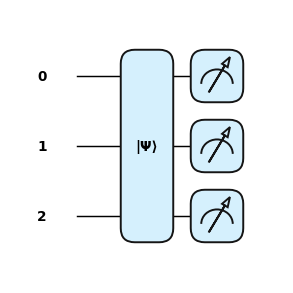

In [5]:
draw_circuit(circuit, level='device', scale=0.7)(f=norm_vect)

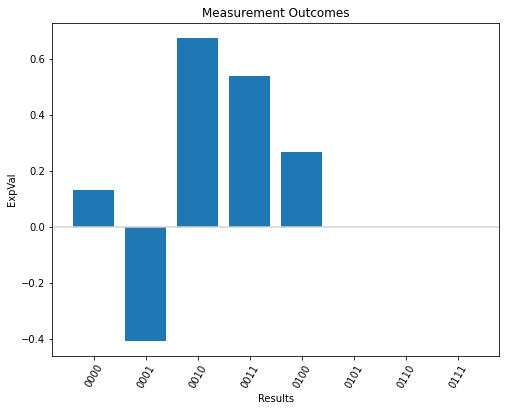

In [6]:
plot_hist(state.real, ylabel='ExpVal', th=-1)

### Basis embedding / encoding

#### Measuring circuit state

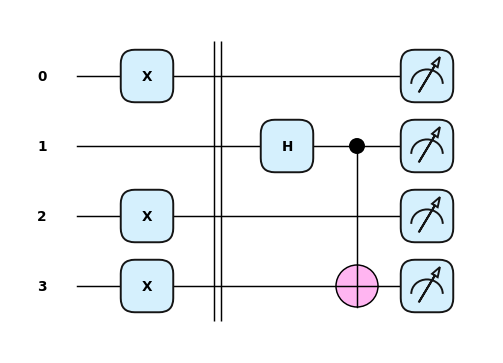

In [7]:
n_wires = 4
dev = qml.device('default.qubit', wires=n_wires)

@qml.qnode(dev)
def basis_circuit_1(features):
    # qml.BasisEmbedding(features=features, wires=range(len(feature_vector)))
    for i in range(len(features)):
        if features[i] == 1: qml.PauliX(i)
    qml.Barrier()
    qml.Hadamard(1)
    qml.CNOT([1, 3])
    return qml.state()

X = [1, 0, 1, 1]

draw_circuit(basis_circuit_1, level='user', scale=0.7)(X)


 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j
 0.        +0.j 0.        +0.j 0.70710678+0.j 0.        +0.j] 



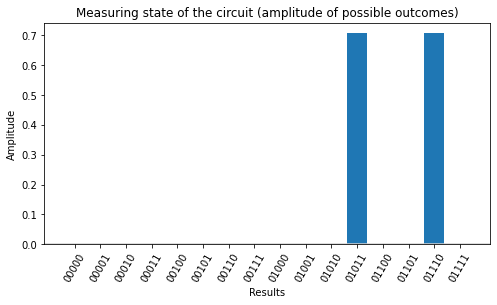

In [8]:
state = basis_circuit_1(X)
print('\n', state, '\n')
plot_hist(state.real, figsize=(8, 4), ylabel='Amplitude', title='Measuring state of the circuit (amplitude of possible outcomes)')

#### Measuring expectation

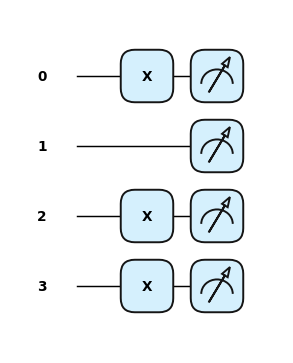

In [9]:
@qml.qnode(dev)
def basis_circuit_2(features):
    for i in range(len(features)):
        if features[i] == 1: qml.PauliX(i)
    return [qml.expval(qml.PauliZ(m)) for m in range(len(features))]

X = [1, 0, 1, 1]

draw_circuit(basis_circuit_2, level='device', scale=0.7)(X)


Expectation values: [-1.  1. -1. -1.]



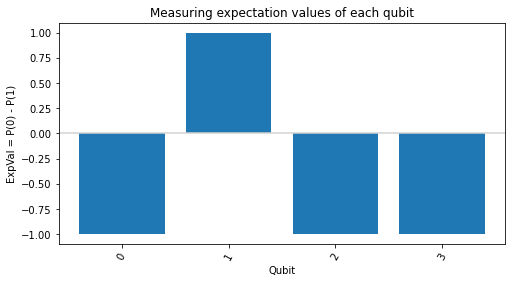

In [10]:
expvals = basis_circuit_2(X)
print(f'\nExpectation values: {np.array(expvals)}\n')
plot_hist(expvals, figsize=(8, 4), ylabel='ExpVal = P(0) - P(1)', xlabel='Qubit',
          title='Measuring expectation values of each qubit',
          labels=[str(i) for i in range(len(X))])

#### Measuring probabilities

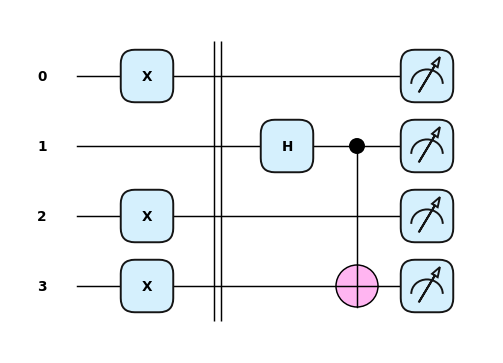

In [11]:
@qml.qnode(dev)
def basis_circuit_3(features):
    for i in range(len(features)):
        if features[i] == 1: qml.PauliX(i)
    qml.Barrier()
    qml.Hadamard(1)
    qml.CNOT([1, 3])
    return qml.probs(range(len(features)))

X = [1, 0, 1, 1]

draw_circuit(basis_circuit_3, level='user', scale=0.7)(X)


 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.5 0. ] 



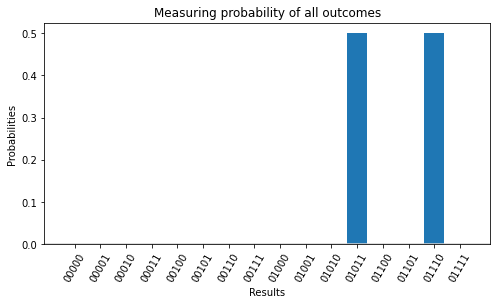

In [12]:
probs = basis_circuit_3(X)
print('\n', probs, '\n')
plot_hist(probs, figsize=(8, 4), ylabel='Probabilities', title='Measuring probability of all outcomes')

#### Spliting circuit observations into measured variables

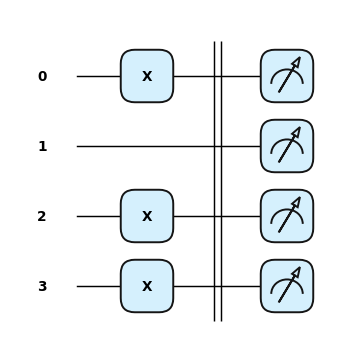

In [13]:
@qml.qnode(dev)
def basis_circuit_4(features):
    for i in range(len(features)):
        if features[i] == 1: qml.PauliX(i)
    qml.Barrier()
    return [qml.probs(range(len(features) // 2)), qml.probs(range(len(features) // 2, len(features)))]

X = [1, 0, 1, 1]

draw_circuit(basis_circuit_4, level='user', scale=0.7)(X)


 [array([0., 0., 1., 0.]), array([0., 0., 0., 1.])] 



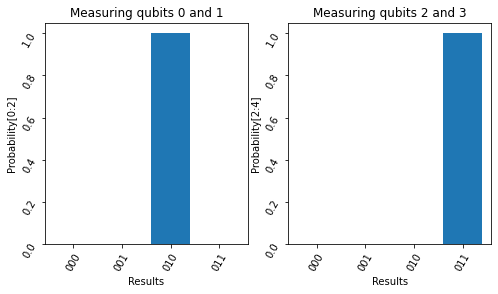

In [14]:
probs = basis_circuit_4(X)
print('\n', probs, '\n')
# plot_hist(probs[0], ylabel='Probabilities[0:2]')
# plot_hist(probs[1], ylabel='Probabilities[2:4]')

plot_compare_hist(probs[0], probs[1], figsize=(8, 4),
                      title_1='Measuring qubits 0 and 1', title_2='Measuring qubits 2 and 3',
                      xlabel_1='Results', xlabel_2='Results',
                      ylabel_1='Probability[0:2]', ylabel_2='Probability[2:4]')

### Angle embedding / encoding

#### Measuring probabilities

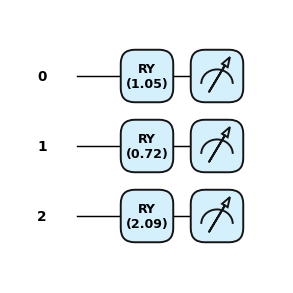

In [15]:
import numpy as np 

n_wires = 3
dev = qml.device('default.qubit', wires=n_wires)

@qml.qnode(dev)
def basis_circuit_ang1a(features):
    qml.AngleEmbedding(features=features, rotation='Y', wires=range(len(features)))
    return qml.probs(range(len(features)))

@qml.qnode(dev)
def basis_circuit_ang1b(features):
    qml.AngleEmbedding(features=features, rotation='Y', wires=range(len(features)))
    return [qml.probs(m) for m in range(len(features))]

X = [np.arccos(0.5), np.arccos(0.75), np.pi-np.arccos(0.5)]

draw_circuit(basis_circuit_ang1a, level='device', scale=0.7)(X)


Input
Values entered:	[np.arccos(0.5), np.arccos(0.75), np.pi-np.arccos(0.5)]
Ry angles used:	[1.047, 0.723, 2.094]

Measurements
Probabilities:	[0.164, 0.492, 0.023, 0.07, 0.055, 0.164, 0.008, 0.023]



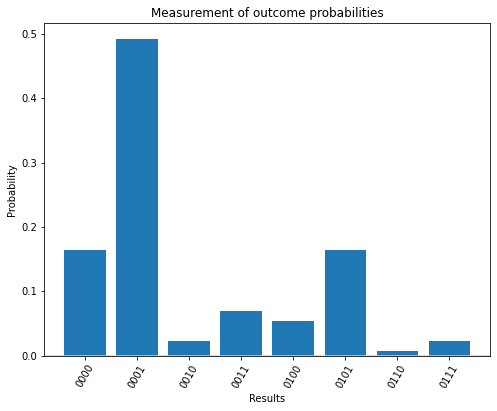

In [16]:
### Get the whole distribution of outcomes
dist_probs = np.array(basis_circuit_ang1a(X))

print('\nInput')
print(f'Values entered:\t[np.arccos(0.5), np.arccos(0.75), np.pi-np.arccos(0.5)]')
print(f'Ry angles used:\t{list(np.round(X, 3))}')
print('\nMeasurements')
print(f'Probabilities:\t{list(np.round(dist_probs, 3))}\n')

plot_hist(dist_probs, ylabel='Probability', title='Measurement of outcome probabilities')

In [17]:
print('\nOriginal probability distribution\n')
display(report_c2p(dist_probs, prec=3))
qprobs = cprobs_to_qprobs(dist_probs)
print(f'\nResult of mapping a circuit state to\nindividual qubit states:\n\n{np.round(qprobs, 3)}\n')


Original probability distribution



[([0, 0, 0], 0.164),
 ([0, 0, 1], 0.492),
 ([0, 1, 0], 0.023),
 ([0, 1, 1], 0.07),
 ([1, 0, 0], 0.055),
 ([1, 0, 1], 0.164),
 ([1, 1, 0], 0.008),
 ([1, 1, 1], 0.023)]


Result of mapping a circuit state to
individual qubit states:

[0.75  0.875 0.25 ]




Input
Values entered:	[np.arccos(0.5), np.arccos(0.75), np.pi-np.arccos(0.5)]
Ry angles used:	[1.047, 0.723, 2.094]

Measurements
Cond probs:	[[0.75, 0.25], [0.875, 0.125], [0.25, 0.75]]

Amplitudes:	[0.866, 0.935, 0.5]



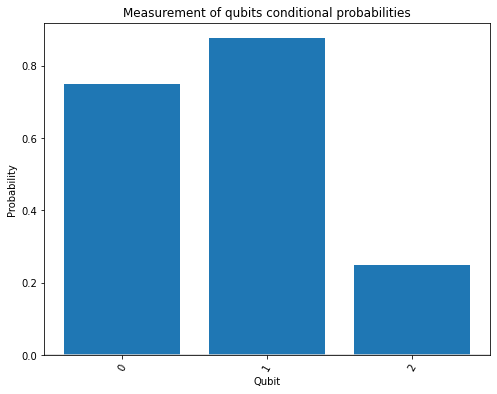

In [18]:
### Get conditional probabilities of each qubit P(0)
probs = np.array(basis_circuit_ang1b(X))

cond_probs = [ps[0] for ps in probs]
amps = np.sqrt([ps[0] for ps in probs])
print('\nInput')
print(f'Values entered:\t[np.arccos(0.5), np.arccos(0.75), np.pi-np.arccos(0.5)]')
print(f'Ry angles used:\t{list(np.round(X, 3))}')
print('\nMeasurements')
print(f'Cond probs:\t{[ list(e) for e in (np.round(probs, 5))]}\n')
print(f'Amplitudes:\t{list(np.round(amps, 3))}\n')
plot_hist(cond_probs, labels=['0', '1', '2'], xlabel='Qubit', ylabel='Probability', 
          title='Measurement of qubits conditional probabilities')

#### Measuring expectations

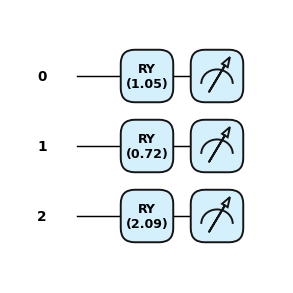

In [19]:
import numpy as np 

n_wires = 3
dev = qml.device('default.qubit', wires=n_wires)

@qml.qnode(dev)
def basis_circuit_ang2(features):
    qml.AngleEmbedding(features=features, rotation='Y', wires=range(len(features)))
    return [qml.expval(qml.PauliZ(m)) for m in range(len(features))]

X = [np.arccos(0.5), np.arccos(0.75), np.pi-np.arccos(0.5)]

draw_circuit(basis_circuit_ang2, level='device', scale=0.7)(X)


Input
Values entered:	[np.arccos(0.5), np.arccos(0.75), np.pi-np.arccos(0.5)]
Ry angles used:	[1.047, 0.723, 2.094]

Measurements
Probabilities:	[[0.25, 0.75], [0.562, 0.438], [0.25, 0.75]]
Amplitudes:	[0.5, 0.75, -0.5]



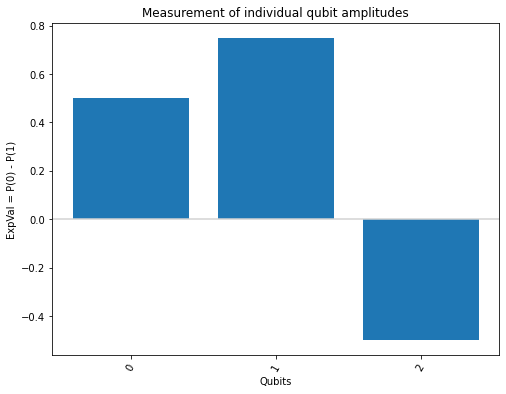

In [20]:
amps = np.array(basis_circuit_ang2(X))
probs = [[p0, 1 - p0] for p0 in np.square(amps)]
print('\nInput')
print(f'Values entered:\t[np.arccos(0.5), np.arccos(0.75), np.pi-np.arccos(0.5)]')
print(f'Ry angles used:\t{list(np.round(X, 3))}')
print('\nMeasurements')
print(f'Probabilities:\t{[ list(e) for e in (np.round(probs, 3))]}')
print(f'Amplitudes:\t{list(np.round(amps, 3))}\n')
plot_hist(amps, xlabel='Qubits', ylabel='ExpVal = P(0) - P(1)', labels=['0', '1', '2'], 
          title='Measurement of individual qubit amplitudes')

## Software (Linux)

In [21]:
import os
os.system('pip list | grep -e PennyLane -e torch');

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
PennyLane_Lightning_GPU   0.40.0
PennyLane-Rigetti         0.40.0
torch                     2.6.0+cu126
torch-geometric           2.6.1
torchaudio                2.6.0+cu126
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cu126
